<div style="border:solid steelblue 1px; padding: 20px">
<b>Задача - построить модель для расчета xG, базируясь на предоставленных данных.</b><br />
<br />
Если вы не знаете, что такое xG - это вероятность того, что удар игрока будет голом.<br />
<br />
<b>Описание данных:</b> <br />
event - событие<br />
is_goal - результат (гол / не гол)<br />
period - период события<br />
time - время события в секундах (с начала периода)<br />
distance - дистанция броска<br />
angle - угол броска (схема)<br />
is_rebound - был ли бросок добиванием<br />
is_pass_before - был ли бросок после передачи<br />
is_cross_line - были ли бросок после пересечения шайбой оси Х (проходит от центра ворот до середины площадки)<br />
is_one_touch - был ли бросок в одно касание<br />
is_fast_attack - была ли атака без передач назад <br />  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, plot_confusion_matrix

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(r'D:\DS\GitHub\shot\shots.csv')

In [4]:
df.info()
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14410 entries, 0 to 14409
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event           14410 non-null  object 
 1   is_goal         14410 non-null  bool   
 2   period          14410 non-null  int64  
 3   time            14410 non-null  float64
 4   distance        14410 non-null  float64
 5   angle           14410 non-null  float64
 6   is_rebound      14410 non-null  bool   
 7   is_pass_before  14410 non-null  bool   
 8   is_cross_line   14410 non-null  bool   
 9   is_one_touch    14410 non-null  bool   
 10  is_fast_attack  14410 non-null  bool   
dtypes: bool(6), float64(3), int64(1), object(1)
memory usage: 647.4+ KB


,event,is_goal,period,time,distance,angle,is_rebound,is_pass_before,is_cross_line,is_one_touch,is_fast_attack
0,Shot Attempt - Wide left,False,1,1071.6,17.4,44.492971,False,False,False,False,False
1,Shot Attempt - Blocked,False,1,519.2,12.9,46.694647,False,False,False,False,False
2,Shot Attempt - Deflected,False,2,742.9,20.6,59.284706,False,False,False,False,False
3,Shot Attempt - Blocked,False,1,210.1,16.6,5.419532,False,True,False,True,False
4,Shot Attempt - Deflected,False,2,599.1,20.1,64.221569,False,False,False,False,False
5,Shot Attempt - Blocked,False,3,313.4,7.6,0.671568,False,False,False,False,False
6,Shot Attempt - Blocked,False,1,473.4,23.7,54.610680,False,False,False,False,False
7,Shot Attempt - Wide right,False,3,157.0,14.3,58.172553,False,True,False,True,False
8,Shot Attempt - Blocked,False,1,69.7,20.7,63.690162,False,False,False,False,False
9,Shot Attempt - Lower right,True,1,879.5,3.6,32.195734,False,False,True,False,False


<div style="border:solid steelblue 1px; padding: 20px">
Проверим на дубликаты:

In [5]:
df.duplicated().sum()

0

<div style="border:solid steelblue 1px; padding: 20px">
Заменим "True" и "False" на 1 и 0 соответсвенно

In [6]:
df =  df.applymap(lambda x: 1 if x == True else x)
df =  df.applymap(lambda x: 0 if x == False else x)

In [7]:
df.head()

,event,is_goal,period,time,distance,angle,is_rebound,is_pass_before,is_cross_line,is_one_touch,is_fast_attack
0,Shot Attempt - Wide left,0,1,1071.6,17.4,44.492971,0,0,0,0,0
1,Shot Attempt - Blocked,0,1,519.2,12.9,46.694647,0,0,0,0,0
2,Shot Attempt - Deflected,0,2,742.9,20.6,59.284706,0,0,0,0,0
3,Shot Attempt - Blocked,0,1,210.1,16.6,5.419532,0,1,0,1,0
4,Shot Attempt - Deflected,0,2,599.1,20.1,64.221569,0,0,0,0,0


<div style="border:solid steelblue 1px; padding: 20px">
Заменим угол атаки с градусов на радианы <br />Для уменьшения мультиколлинеарности нужно удалить признак angle, т.к. он будет линейно зависимым с новым признаком rad.<br />
Вычислим проекции дистанции

In [8]:
df['rad'] = df['angle']/57.297

In [9]:
df=df.drop(['angle'],axis=1)

In [10]:
df['cos_rad'] = np.cos(df['rad'])
df['sin_rad'] = np.sin(df['rad'])
df['distance_center'] = df['cos_rad'] * df['distance']
df['distance_goal'] = df['sin_rad'] * df['distance']

<div style="border:solid steelblue 1px; padding: 20px">
Вычислим время броска от начала матча

In [11]:
df['full_time']=df['time']+(df['period']-1)*1200

In [12]:
df.head()

,event,is_goal,period,time,distance,is_rebound,is_pass_before,is_cross_line,is_one_touch,is_fast_attack,rad,cos_rad,sin_rad,distance_center,distance_goal,full_time
0,Shot Attempt - Wide left,0,1,1071.6,17.4,0,0,0,0,0,0.776532,0.713348,0.700810,12.412256,12.194093,1071.6
1,Shot Attempt - Blocked,0,1,519.2,12.9,0,0,0,0,0,0.814958,0.685899,0.727697,8.848097,9.387288,519.2
2,Shot Attempt - Deflected,0,2,742.9,20.6,0,0,0,0,0,1.034691,0.510791,0.859705,10.522302,17.709917,1942.9
3,Shot Attempt - Blocked,0,1,210.1,16.6,0,1,0,1,0,0.094587,0.995530,0.094446,16.525798,1.567799,210.1
4,Shot Attempt - Deflected,0,2,599.1,20.1,0,0,0,0,0,1.120854,0.434914,0.900472,8.741764,18.099491,1799.1


<div style="border:solid steelblue 1px; padding: 20px">
 Создадим тестовую и обучающую выборку

In [13]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

<div style="border:solid steelblue 1px; padding: 20px">
Так как колонка "event" содержит данные о наличии гола, то уберем её из обучения, что бы избежать некорректной работы модели

In [14]:
y_train = df_train['is_goal']
x_train=df_train.drop(['is_goal','event'], axis=1)

y_test = df_test['is_goal']
x_test=df_test.drop(['is_goal','event'], axis=1)

<div style="border:solid steelblue 1px; padding: 20px">
Для подбора гиперпараметров будем использовать GridSearchCV
    
Напишем функцию model_learning - принимающая модель и сетку параметров, обучает и возвращает лучшую модель на обучениии.

In [15]:
def model_learning(model, parameters,features_train,target_train):
    cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=42)
    grid_model = GridSearchCV(model, parameters, scoring='roc_auc', cv=cv, verbose=3)
    grid_model.fit(features_train, target_train)
    print('Лучшая оценка на валидации: ', grid_model.best_score_)
    print('Лучшие гиперпараметры модели на валидации: ', grid_model.best_params_)
    print('Лучшая модель: ', grid_model.best_estimator_)
    return grid_model.best_estimator_

<div style="border:solid steelblue 1px; padding: 20px">
Для оценки качества модели по ROC-AUC напишем функцию test_scoring, принимает обученную модель и дает оценки на тестовой выборке и строит ROC-AUC кривую:

In [16]:
def test_scoring(model,features_test, target_test):
    pred_proba_test = model.predict_proba(features_test)[:, 1]
    pred_test = model.predict(features_test)
    print('Accuracy: ', round(model.score(features_test, target_test), 3))
    print('AUC-ROC: ', round(roc_auc_score(target_test, pred_proba_test), 3))
    fpr, tpr, thresholds = roc_curve(target_test, pred_proba_test)

    sns.set()
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')
    plt.show()

In [17]:
x_train.head()

,period,time,distance,is_rebound,is_pass_before,is_cross_line,is_one_touch,is_fast_attack,rad,cos_rad,sin_rad,distance_center,distance_goal,full_time
5049,1,98.2,20.0,0,0,0,0,1,0.972554,0.563191,0.826327,11.263812,16.526540,98.2
4192,1,985.8,16.6,0,1,0,1,0,0.789990,0.703853,0.710346,11.683955,11.791743,985.8
10604,2,127.7,2.3,0,1,0,1,0,0.917930,0.607466,0.794346,1.397171,1.826996,1327.7
13111,3,751.7,4.7,0,0,0,0,0,1.174330,0.386161,0.922431,1.814957,4.335427,3151.7
9969,3,632.5,10.5,0,0,0,0,0,0.763488,0.722429,0.691445,7.585504,7.260174,3032.5


<div style="border:solid steelblue 1px; padding: 20px">
CatBoost

In [18]:
%%time

CatBoost_cl = CatBoostClassifier(random_state=42, verbose=0)
CatBoost_cl_param = {'n_estimators': [300, 500],
                      'learning_rate': [0.1, 1],
                      'max_depth': [1, 5],
                      'l2_leaf_reg': [1, 3]}

CatBoost_fitted = model_learning(CatBoost_cl, CatBoost_cl_param,x_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END l2_leaf_reg=1, learning_rate=0.1, max_depth=1, n_estimators=300;, score=0.769 total time=   0.8s
[CV 2/3] END l2_leaf_reg=1, learning_rate=0.1, max_depth=1, n_estimators=300;, score=0.762 total time=   0.6s
[CV 3/3] END l2_leaf_reg=1, learning_rate=0.1, max_depth=1, n_estimators=300;, score=0.729 total time=   0.5s
[CV 1/3] END l2_leaf_reg=1, learning_rate=0.1, max_depth=1, n_estimators=500;, score=0.766 total time=   0.8s
[CV 2/3] END l2_leaf_reg=1, learning_rate=0.1, max_depth=1, n_estimators=500;, score=0.757 total time=   0.9s
[CV 3/3] END l2_leaf_reg=1, learning_rate=0.1, max_depth=1, n_estimators=500;, score=0.724 total time=   0.8s
[CV 1/3] END l2_leaf_reg=1, learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.711 total time=   0.8s
[CV 2/3] END l2_leaf_reg=1, learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.727 total time=   0.8s
[CV 3/3] END l2_leaf_reg=1, learning_rate=0.1, max_depth=5,

<div style="border:solid steelblue 1px; padding: 20px">
LGBM

<div style="border:solid steelblue 1px; padding: 20px">
Преобразуем категориальные признаки

In [19]:
columns = x_train.columns.tolist()

In [20]:
categ_features=columns[4:8]
categ_features

['is_pass_before', 'is_cross_line', 'is_one_touch', 'is_fast_attack']

In [21]:
x_train_l=x_train
x_test_l=x_test
x_train_l.loc[:, categ_features] = x_train.loc[:, categ_features].astype("category")
x_test_l.loc[:, categ_features] = x_test.loc[:, categ_features].astype("category")
x_train_l.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10807 entries, 5049 to 7270
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   period           10807 non-null  int64   
 1   time             10807 non-null  float64 
 2   distance         10807 non-null  float64 
 3   is_rebound       10807 non-null  int64   
 4   is_pass_before   10807 non-null  category
 5   is_cross_line    10807 non-null  category
 6   is_one_touch     10807 non-null  category
 7   is_fast_attack   10807 non-null  category
 8   rad              10807 non-null  float64 
 9   cos_rad          10807 non-null  float64 
 10  sin_rad          10807 non-null  float64 
 11  distance_center  10807 non-null  float64 
 12  distance_goal    10807 non-null  float64 
 13  full_time        10807 non-null  float64 
dtypes: category(4), float64(8), int64(2)
memory usage: 971.4 KB


In [22]:
lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=42)
lgbm_clf_param = {'n_estimators': [300, 500, 1000],
                  'learning_rate': [0.01, 0.1, 1],
                  'max_depth': [1, 5, 9]}
    
lgbm_clf_fitted = model_learning(lgbm_clf, lgbm_clf_param,x_train_l,y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.01, max_depth=1, n_estimators=300;, score=0.770 total time=   0.1s
[CV 2/3] END learning_rate=0.01, max_depth=1, n_estimators=300;, score=0.761 total time=   0.0s
[CV 3/3] END learning_rate=0.01, max_depth=1, n_estimators=300;, score=0.728 total time=   0.0s
[CV 1/3] END learning_rate=0.01, max_depth=1, n_estimators=500;, score=0.772 total time=   0.1s
[CV 2/3] END learning_rate=0.01, max_depth=1, n_estimators=500;, score=0.763 total time=   0.1s
[CV 3/3] END learning_rate=0.01, max_depth=1, n_estimators=500;, score=0.731 total time=   0.1s
[CV 1/3] END learning_rate=0.01, max_depth=1, n_estimators=1000;, score=0.776 total time=   0.2s
[CV 2/3] END learning_rate=0.01, max_depth=1, n_estimators=1000;, score=0.762 total time=   0.2s
[CV 3/3] END learning_rate=0.01, max_depth=1, n_estimators=1000;, score=0.731 total time=   0.2s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=300;, score=0

<div style="border:solid steelblue 1px; padding: 20px">
LGBM показала лучший результат

Accuracy:  0.951
AUC-ROC:  0.75


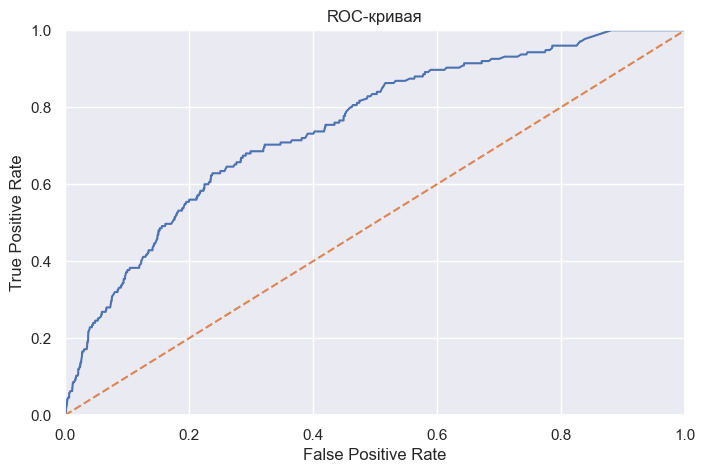

In [23]:
test_scoring(lgbm_clf_fitted,x_test,y_test)

<div style="border:solid steelblue 1px; padding: 20px">
    Выведем значимость признаков

Text(0.5, 1.0, 'Feature Importance')

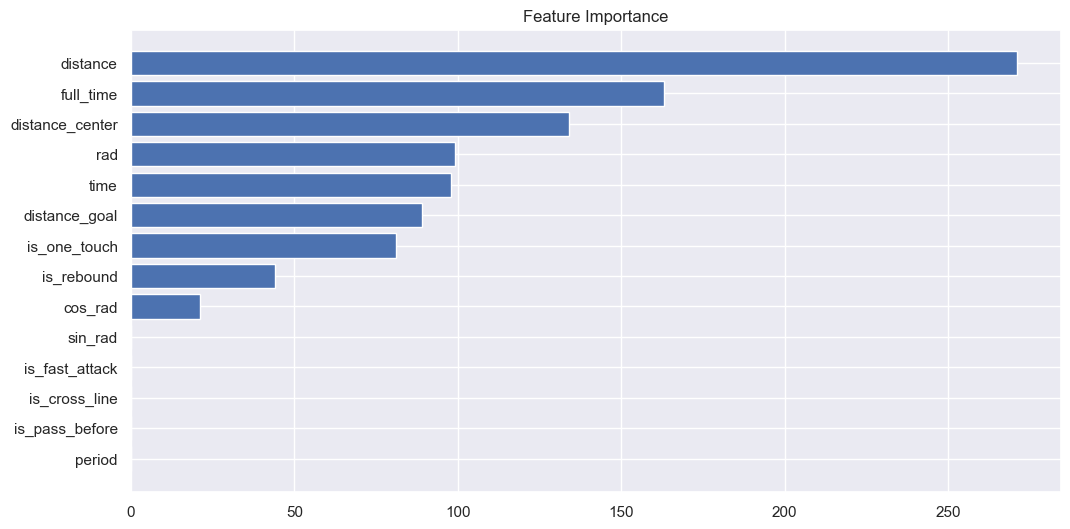

In [24]:
feature_importance = lgbm_clf_fitted.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
plt.title('Feature Importance')

<div style="border:solid steelblue 1px; padding: 20px">
<b>Выводы.</b><br />
В ходе работы было реализовано:
    * первичный анализ данных(пропуски и дубликаты отсутствуют)<br />
    * добавоены новые признаки(проекции дистанции, замена угла с градусов на радианы, время удара с начала игры) <br />
    * две модели(LGBM и CatBoost). LGBM показала лучший результат(ROC-AUC 0.756) <br />
    * LGBM на тестовой выборке показала результат ROC-AUC 0.75
    * Основной вклад вносит признак "distance"